# DRAFT STATE

Warning: This unit is in a draft state, with TODOs.

Remove this text block when these are resolved. 

# Exercise: Gradient Descent

We've discussed the basics of gradient descent, and we know there are multiple variations of this. Here, we will work with batch gradient descent and explore how changing the learning rate can alter its behaviour.

The model we will be working with will be a simple linear regression model - fitting a line to data. The principles we learn, however, apply to much more complex models too.

## Loading data and preparing our model

We will work with weather data from Seattle. Our goal is to be able to predict the minimum daily temperature during the first half of the year.

Let's load our data and restrict it to the first six months of the year

Index(['date', 'amount_of_precipitation', 'max_temperature', 'min_temperature',
       'rain', 'day_of_year'],
      dtype='object')


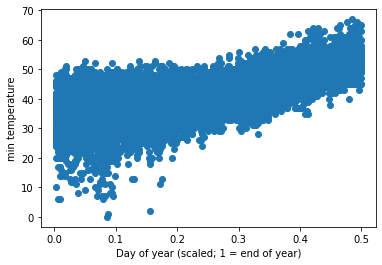

In [18]:
import pandas
from datetime import datetime
import matplotlib.pyplot as graph

# Read the text file containing data using pandas
dataset = pandas.read_csv('seattleWeather_1948-2017.csv', parse_dates=['date'])

# Convert dates into a fraction that indicates how far through they
# year they are. For example, the middle day of the year gets the value 0.5
dataset['day_of_year'] = dataset.date.dt.dayofyear / 365.0

# Only keep the first half of the year
dataset = dataset[dataset.day_of_year <= 0.5]

# delete unwanted columns
print(dataset.columns)
del dataset["amount_of_precipitation"]
del dataset["max_temperature"]
del dataset["rain"]


# Show a graph of min temperature by day of the year:
# -- This first line is a special command that lets this work in Jupyter Notebooks
%matplotlib inline
# -- Create a scatter plot
graph.scatter(dataset.day_of_year, dataset.min_temperature)
# -- Add some labels
graph.ylabel('min temperature')
graph.xlabel("Day of year (scaled; 1 = end of year)")
# -- Show
graph.show()

## Fitting a model automatically

We already know we can fit a line to this data well using existing libraries. Let's do that now.

In [19]:
import statsmodels.formula.api as smf

# Perform linear regression to fit a line to our data
model = smf.ols(formula = "min_temperature ~ day_of_year", data = dataset).fit()

# Print a summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        min_temperature   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                 1.405e+04
Date:                Fri, 30 Apr 2021   Prob (F-statistic):               0.00
Time:                        16:10:38   Log-Likelihood:                -39663.
No. Observations:               12740   AIC:                         7.933e+04
Df Residuals:                   12738   BIC:                         7.934e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      31.8142      0.097    328.483      

Look at the `coef` column. This tells us that the 'best' straight line to fit to this data is:

`y = day_of_year * 39.7 * 31.8`

We know, from our previous exercises, that OLS used the square differences of residuals as a cost function, but how exactly did the library find a model that minimised this cost function? 

## Fitting our model with gradient descent

Let's replicate this line fitting, and break down each step so we can watch it in action.

Recall that for each iteration, our training conducts three steps: 

1) Estimation of y from X

2) Calculating the cost function and its slope

3) Adjusting our model according to this slope

Let's implement this now, to watch it in action. 

### Visualising the error function

First, lets look at the error function for this data. Normally we don't know this in advance, but for learning purposes, we can calculate it now for different potential models

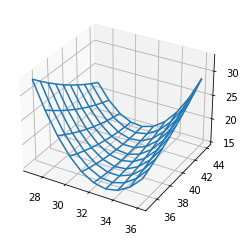

In [36]:
import numpy as np
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
x = dataset.day_of_year
y_true = dataset.min_temperature


# Our cost function can be half the mean of squared differences
def cost_function(y_estimate):
    """
    Our cost function is the mean squared error divided by 2
    """
    # Note that with numpy to square each value we use **
    # We use MSE/2 because it makes the gradient easier to calculate
    mse = np.sum((y_true - y_estimate) ** 2) / (2*len(y_estimate))
    return mse


# TODO - this is horrible code that needs tidying
intercepts = []
slopes = []
errors = []
for intercept in range(27,37):
    for slope in range(35,45):
        error = cost_function(slope * x + intercept)
        intercepts.append(intercept)
        slopes.append(slope)
        errors.append(error)
intercepts = np.array(intercepts).reshape((10,10))
slopes = np.array(slopes).reshape((10,10))
errors = np.array(errors).reshape((10,10))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# TODO add axis labels - this shows parameters vs the error we will hit
ax.plot_wireframe(intercepts, slopes, errors)

plt.show()

Notice how the curve above is a 2D surface - it changes with both intercept and with line slope. This makes sense - a line has a slope and an intercept, which both will affect how well the line fits the data. A consequence is that the gradient of the cost function must also be described by two numbers - one for intercept, and one for line slope.

Our lowest point on the graph is the location of the best line equation for our data: a slope of 39.7 and intercept of 31.8. Let's try to train a model to find this point

### Implementing Gradient Descent

First we need a method that can calculate the gradient of the above curve. 

In [38]:
def calculate_gradient(y_estimate):
    """
    Our cost function is MSE/2
    ssd = mean((predicted - actual)^2)
    """

    # The partial derivatives of MSE/2 are as follows
    # You don't need to be able to do this just yet but
    # it is important to note these give you the two gradients
    # that we need to train our model
    error = y_estimate - y_true
    grad_intercept = np.mean(error)
    grad_slope = (x * error).sum() / x.shape[0]

    return grad_intercept, grad_slope

Now we need a starting guess, and a loop that will update this guess with each iteration 

In [39]:
def gradient_descent(learning_rate, number_of_iterations):
    """
    Performs gradient descent for a one-variable function. 

    learning_rate: Larger numbers follow the gradient more aggressively
    number_of_iterations: The maximum number of iterations to perform
    """
    # Our starting guess is y = 0 * x + 0
    estimated_intercept = 0
    estimated_slope = 0

    for i in range(number_of_iterations):
        # Calculate the predicted values
        predicted_y = estimated_slope * x + estimated_intercept

        # Calculate the gradient
        grad_intercept, grad_slope = calculate_gradient(predicted_y)

        # Update the estimation of the line
        estimated_intercept -= learning_rate * grad_intercept 
        estimated_slope -= learning_rate * grad_slope

        # Print the current estimation every 100 iterations
        if( i % 100 == 0):
            print(f"Next estimate: y={estimated_slope}x + {estimated_intercept}")

    # Print the final model
    print(f"Final estimate: y={estimated_slope}x + {estimated_intercept}")

# Run gradient descent
gradient_descent(learning_rate=0.4, number_of_iterations=1000)

Next estimate: y=4.517788520676976x + 16.708634222919937
Next estimate: y=26.26067491930104x + 35.25543420267613
Next estimate: y=33.562207707678446x + 33.38870319360369
Next estimate: y=36.90298404178705x + 32.53459064518333
Next estimate: y=38.431537954782655x + 32.143796126946015
Next estimate: y=39.130919425214955x + 31.964990235653595
Next estimate: y=39.45091758623851x + 31.883178579479196
Next estimate: y=39.597330992065814x + 31.84574610430949
Next estimate: y=39.664321643941335x + 31.8286190803272
Next estimate: y=39.69497284977426x + 31.820782704315185
Final estimate: y=39.70890428942101x + 31.817220952126522


Our model found the correct answer, but it took a number of steps. Looking at the print out we can see how it progressively stepped toward the correct solution.

Now, what happens if we make the learning rate faster? This means taking larger steps

In [41]:
gradient_descent(learning_rate=1, number_of_iterations=500)

Next estimate: y=11.294471301692438x + 41.771585557299844
Next estimate: y=35.65147159128489x + 32.854555941143026
Next estimate: y=39.151215290312344x + 31.95980133603055
Next estimate: y=39.64109449308954x + 31.834557400951667
Next estimate: y=39.70966569542656x + 31.817026288863033
Final estimate: y=39.71923297869127x + 31.814580289528312


It appears to have found the solution faster. If we increase the rate even faster, however, things don't go so well:

In [43]:
gradient_descent(learning_rate=2, number_of_iterations=1000)

Next estimate: y=22.588942603384876x + 83.54317111459969
Next estimate: y=1965139.5951741515x + 7686326.877683327
Next estimate: y=339851113371.8435x + 1329293848530.1804
Next estimate: y=5.8775001309449384e+16x + 2.2989257536955424e+17
Next estimate: y=1.0164747571533523e+22x + 3.9758399747165516e+22
Next estimate: y=1.7579258339614092e+27x + 6.875952161196914e+27
Next estimate: y=3.0402164106498307e+32x + 1.1891504291854518e+33
Next estimate: y=5.257853115882598e+37x + 2.0565569830634018e+38
Next estimate: y=9.093109060051212e+42x + 3.556679223068461e+43
Next estimate: y=1.5725930442639523e+48x + 6.15104137642893e+48
Final estimate: y=-2.410689417379238e+53x + -9.429172032844236e+53


As we can see, the model became unstable and it did not manage to find the correct solution. 

This is because the steps it was taking were too large. While it would step towards the correct solution, it would step too far and actually get worse with each attempt.

For each model, there is an ideal learning rate. This is something that requires experimentation.

## Summary

Well done! In this unit we have:

1) watched gradient descent in action

2) seen how changing the learning rate can improve a model's training speed

3) learned that changing the learning rate can also result in unstable models 